In [127]:
#*********************@Author: Aniruddh Khera*********************
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb  
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = pd.read_csv("prices-split-adjusted.csv")

/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/home/aniruddh/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)


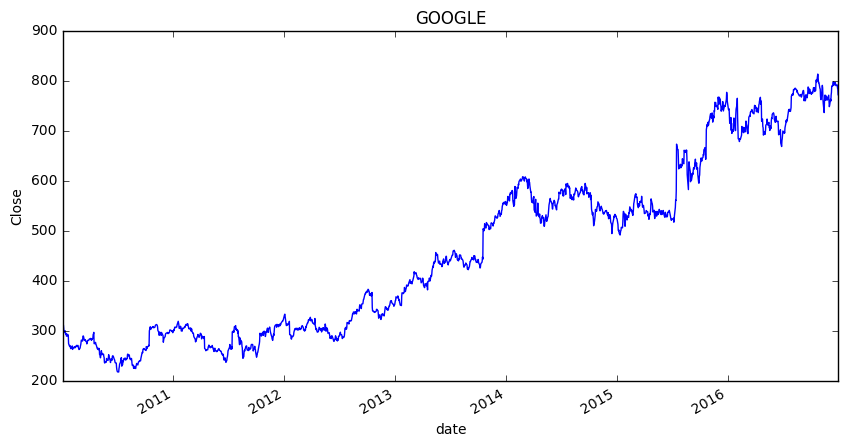

In [128]:
#**********************EXPLORATORY ANALYSIS**********************
#select google
goog = df[df.symbol == 'GOOG']
goog.date = goog.date.convert_objects(convert_dates='coerce')
goog = goog.sort_index(by="date")
goog = goog.set_index("date")
goog['close'].plot(figsize=(10,5), title="GOOGLE").set_ylabel("Close")

In [129]:
# Split data into training & testing
goog_train = goog[goog.index<'2016-01-01']
goog_test = goog[goog.index>='2016-01-01']

/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


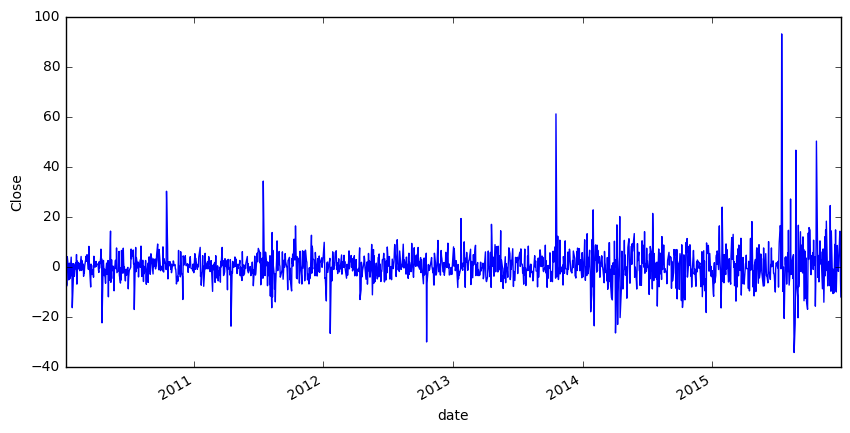

In [130]:
# Clearly unstationary 
# Take 1st difference
goog_train['First Difference'] = goog_train['close'] - goog_train['close'].shift()  
goog_train['First Difference'].plot(figsize=(10, 5)).set_ylabel("Close")  

/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


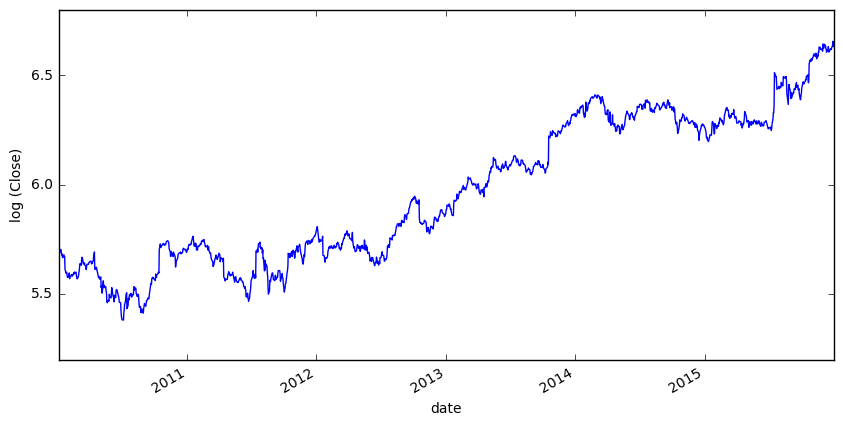

In [131]:
# Exponential smoothing by taking log to make variance constant
goog_train['Natural Log'] = goog_train['close'].apply(lambda x: np.log(x))  
goog_train['Natural Log'].plot(figsize=(10, 5)).set_ylabel("log (Close)") 

/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).var()
  if __name__ == '__main__':
/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=True).var()
  from ipykernel import kernelapp as app
/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingW

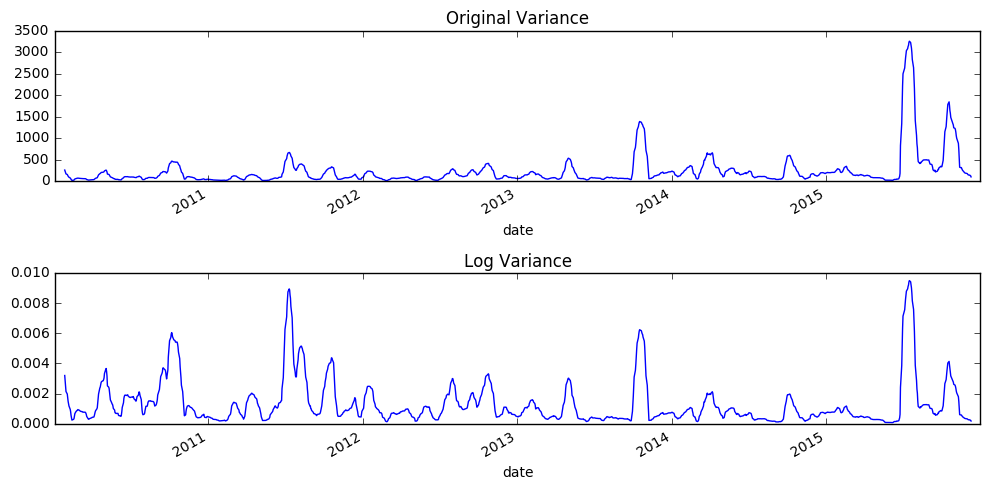

In [132]:
goog_train['Original Variance'] = pd.rolling_var(goog_train['close'], 30, min_periods=None, freq=None, center=True)  
goog_train['Log Variance'] = pd.rolling_var(goog_train['Natural Log'], 30, min_periods=None, freq=None, center=True)

fig, ax = plt.subplots(2, 1, figsize=(10, 5))  
goog_train['Original Variance'].plot(ax=ax[0], title='Original Variance')  
goog_train['Log Variance'].plot(ax=ax[1], title='Log Variance')  
fig.tight_layout()  

/home/aniruddh/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


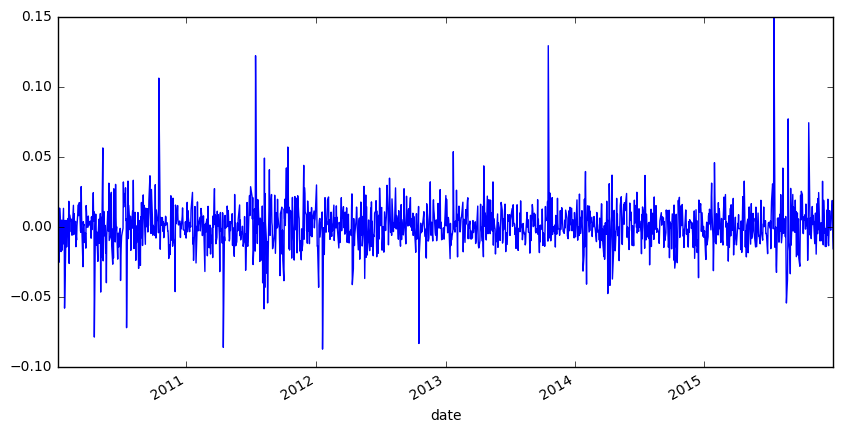

In [142]:
goog_train['Logged First Difference'] = goog_train['Natural Log'] - goog_train['Natural Log'].shift()  
goog_train['Logged First Difference'].plot(figsize=(10, 5))  

In [157]:
#Perform Dickey-Fuller test: To get the right difference based on AIC values
print('Results of Dickey-Fuller Test:')
dftest = adfuller(goog_train['Natural Log'],autolag='BIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)
    
# pacf = plot_pacf(goog_train['Natural Log'],lags=40)
# plt.title("PACF Plot of SP 500")

# acf = plot_acf(goog_train['Natural Log'], lags=40)
# plt.title("ACF Plot of SP 500")

Results of Dickey-Fuller Test:
Test Statistic                    0.014746
p-value                           0.959735
#Lags Used                        0.000000
Number of Observations Used    1509.000000
Critical Value (1%)              -3.434691
Critical Value (5%)              -2.863457
Critical Value (10%)             -2.567791
dtype: float64
